## Heart Attack Analysis Report: Group 44

### Introduction

Heart disease is a prevalent and life-threatening condition that affects millions of people worldwide. Early diagnosis and risk assessment are crucial in providing timely medical intervention and reducing the morbidity and mortality associated with this condition. In our data science project, we aim to leverage a [dataset](https://archive.ics.uci.edu/ml/datasets/Heart+Disease) containing hospital data from Cleveland, Hungary, Switzerland, and VA Long Beach. However, we will specifically choose to work with the Cleveland data as it contains the most data from heart disease patients. The dataset contains 14 health-related variables, including the presence or absence of heart disease as the categorical variable. Using classification modelling, the data offers us a valuable opportunity to explore its relationship with heart disease. Hence, we propose to answer the question: Using KNN, how can we use medical laboratory test data available to us to predict whether a patient has heart disease?

## Methods & Results

First, we load all of the packages with the functions that are necessary to work the following data analysis.

In [1]:
library(repr)
library(tidyverse)
library(tidymodels)
library(RColorBrewer)
install.packages("kknn")
install.packages("GGally")
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

We set a seed value in every code block that involves running the analysis to ensure that the randomness in the following is reproducible. Next, we create a vector to rename the 14 columns from the original data set to make it human-readable. 

Then, we read in the heart disease data and store it as `heart_data`. However, for our analysis, we will only be using the following five predictor variables: `cp` (chest pain type), `trestbps` (resting blood pressure), `chol` (serum cholesterol levels), `fbs` (fasting blood sugar), and `restecg` (resting electrocardiogram results). The response variable here will be `num` (diagnosis of heart disease). 

The original data set characterizes a diagnosis of heart disease by the numbers 1, 2, 3, and 4 in varying levels of severity, and a diagnosis of no heart disease by the number 0. In our analysis, we simplify this by setting the diagnosis of heart disease: 0 = no heart disease; 1 = heart disease. 

In [2]:
set.seed(1)
# creating column names for our data as it does not contain
our_col_names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")

# reading in our data and storing as an object
heart_data <- read_csv("data/processed.cleveland.data", col_names = our_col_names) |>
    select(cp, trestbps, chol, fbs, restecg, num) |>
    mutate(num = ifelse(num %in% c(1, 2, 3, 4), 1, num)) |>
    mutate(num = as_factor(num))
    
head(heart_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


cp,trestbps,chol,fbs,restecg,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,145,233,1,2,0
4,160,286,0,2,1
4,120,229,0,2,1
3,130,250,0,0,0
2,130,204,0,2,0
2,120,236,0,0,0


We start the initial splitting of the data into 80% training set and 20% testing set and store it as `train_data` and `test_data`, respectively.

Now, using the training data set, we begin our preliminary exploratory data analysis of the five predictor variables we have chosen to examine. Two of the predictor variables (`trestbps`, `chol`) are continuous, whereas the other three (`cp`, `fbs`, `restecg`) are discrete variables. We start examining the `trestbps` and `chol` variables by calculating its mean values, as well as counting the number of patients who have received a diagnosis of heart disease, or diagnosis of no heart disease. This information gives us a sense of the average blood pressure levels and cholesterol levels of patients obtained from laboratory tests, and it also allows us to gauge the number of patients involved - in other words, the size of this data set.

In [3]:
set.seed(1)

# prepare data for splitting
split_obj <- initial_split(heart_data, prop = 0.8, strata = num)

# split and extract data
train_data <- training(split_obj)
test_data <- testing(split_obj)


# calculcate summary statistics
summary_diagnosis <- train_data |>
    group_by(num) |>
    summarize(count = n()) |>
    pivot_wider(names_from = num,
                values_from = count)

# summary_diagnosis

summary_means <- train_data |>
    select(trestbps, chol) |>
    summarize_all(mean, na.rm = TRUE)

# summary_means

summary_table <- cbind(summary_means, summary_diagnosis) |>
    rename("resting blood pressure (mean)" = trestbps,
          "serum cholesterol (mean)" = chol,
          "no disease" = `0`,
          "disease" = `1`)
           
summary_table

resting blood pressure (mean),serum cholesterol (mean),no disease,disease
<dbl>,<dbl>,<int>,<int>
132.7727,246.4835,131,111


Here, we continue our preliminary exploratory data analysis on the training data by visualizing a scatter plot between the continuous variables, `trestbps` and `chol`, for any potential correlations or relationships. Upon first glance, it appears visually that there is no distinct correlation between the two variables, and also no relationship with the heart disease diagnosis.  

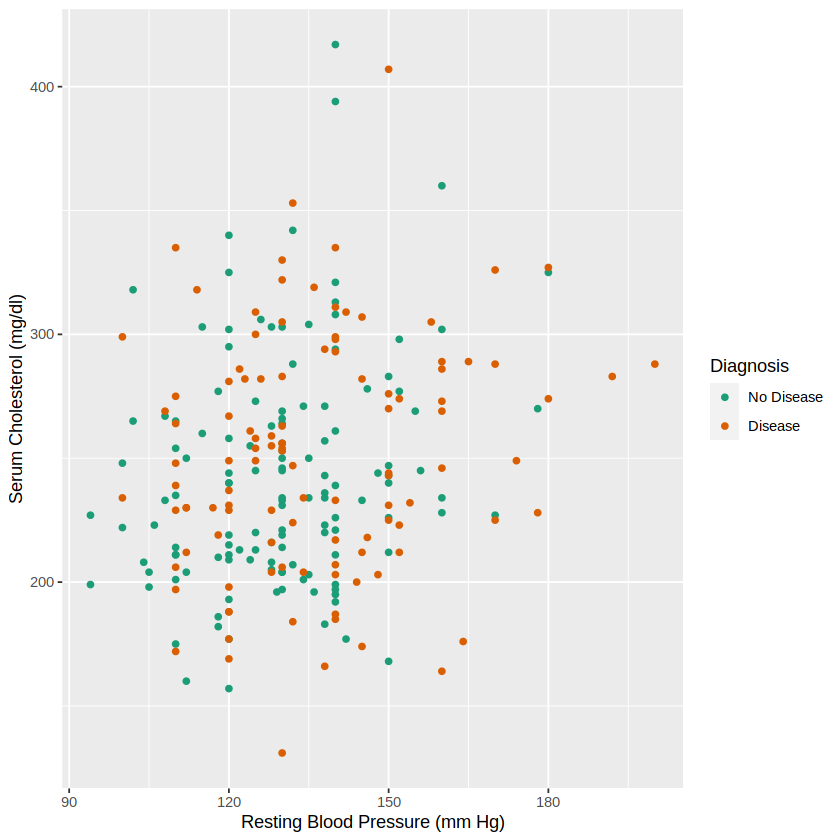

In [4]:
set.seed(1)
visualization1 <- train_data |>
    ggplot(aes(x=trestbps,  y=chol, colour= as_factor(num))) +
    geom_point() +
    labs(x="Resting Blood Pressure (mm Hg)", y="Serum Cholesterol (mg/dl)", colour = "Diagnosis") +
    scale_color_brewer(palette = "Dark2", labels=c("No Disease", "Disease"))

visualization1

Here, we visualize a bar plot of the proportions of patients diagnosed with and without heart disease based on the type of chest pain they reported, where

1 = typical angina,  
2 = atypical angina,  
3 = non-anginal pain,  
4 = asymptomatic.

It appears that majority of the patients who reported having no chest pain were the ones who had heart disease.

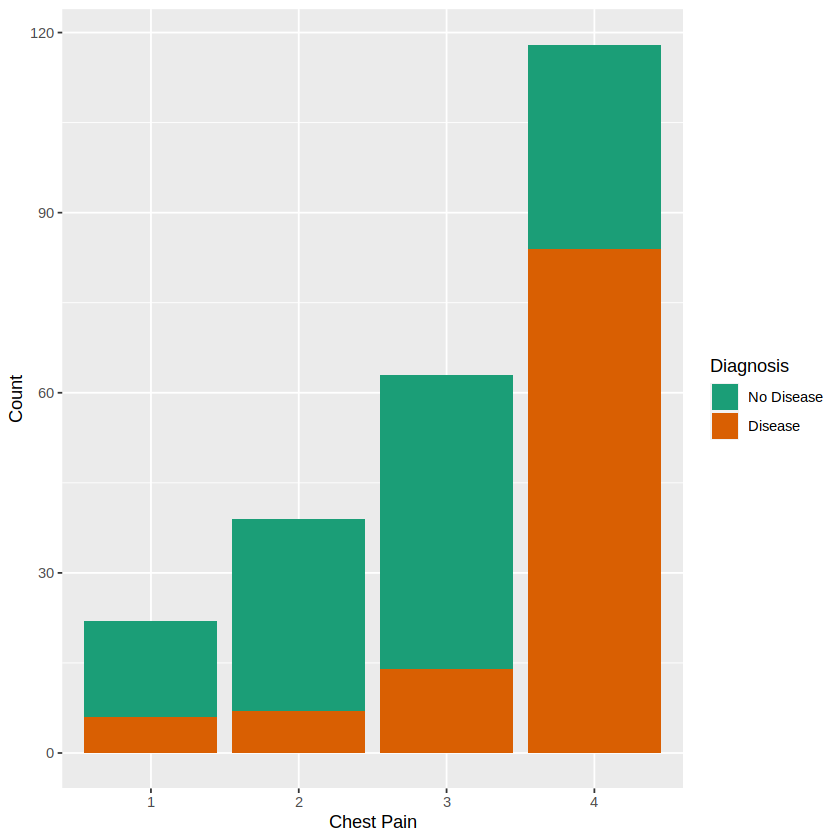

In [5]:
#9 cp: chest pain type
        #-- Value 1: typical angina
        #-- Value 2: atypical angina
        #-- Value 3: non-anginal pain
        #-- Value 4: asymptomatic

set.seed(1)
cat_cp <- train_data |>
    ggplot(aes(x = as_factor(cp), fill = as_factor(num))) +
    geom_bar(stat = "count") + 
    labs(x = "Chest Pain", y = "Count", fill = "Diagnosis") +
    scale_fill_brewer(palette = "Dark2", labels=c("No Disease", "Disease"))

cat_cp

Here, we visualize a bar plot of the proportions of patients diagnosed with and without heart disease based on their fasting blood sugar levels, where

0 = fasting blood sugar level $\leq$ 120 mg/dl,  
1 = fasting blood sugar level $>$ 120 mg/dl.

It appears that majority of the patients' fasting blood sugar levels were below 120mg/dl. There does not seem to be any indication of heart disease based on fasting blood sugar levels.

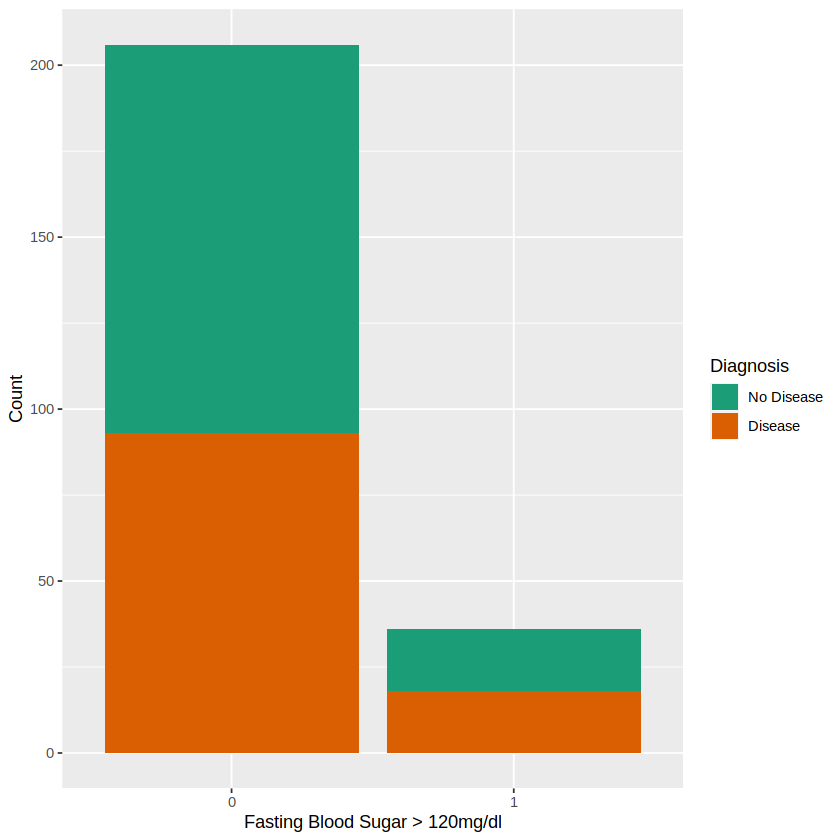

In [6]:
#16 fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
set.seed(1)
cat_fbs <- train_data |>
    ggplot(aes(x = as_factor(fbs), fill = as_factor(num))) +
    geom_bar(stat = "count") + 
    labs(x = "Fasting Blood Sugar > 120mg/dl", y = "Count", fill = "Diagnosis") +
    scale_fill_brewer(palette = "Dark2", labels=c("No Disease", "Disease"))

cat_fbs

Here, we visualize a bar plot of the proportion of patients diagnosed with and without heart disease based on their resting electrocardiographic results, where

0 = normal,  
1 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of $>$ 0.05 mV),  
2 = showing probable or definite left ventricular hypertrophy by Estes' criteria.

It appears that patients who showed ST-T wave abnormality, which also seemed to be extremely rare, and left ventricular hypertrophy were likely to have heart disease.

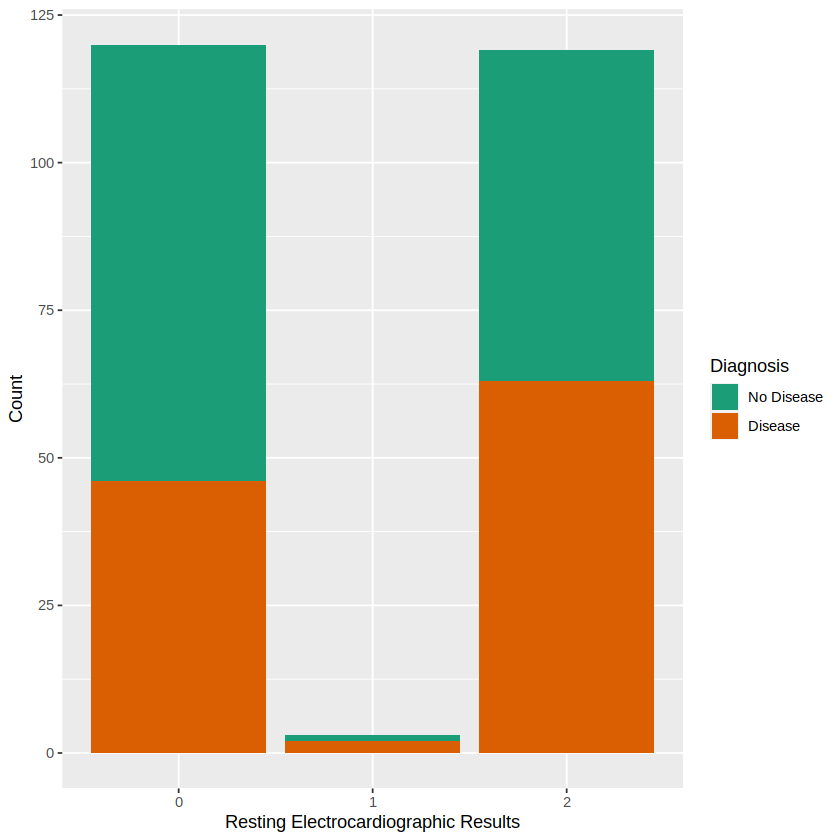

In [7]:
#19 restecg: resting electrocardiographic results
        #-- Value 0: normal
        #-- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
        #-- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

set.seed(1)
cat_restecg <- train_data |>
    ggplot(aes(x = as_factor(restecg), fill = as_factor(num))) +
    geom_bar(stat = "count") +
    labs(x = "Resting Electrocardiographic Results", y = "Count", fill = "Diagnosis") +
    scale_fill_brewer(palette = "Dark2", labels=c("No Disease", "Disease"))

cat_restecg

After visualizing the predictor variables through several plots, we now begin to tune our K-NN classifier to choose the optimal K value. First, we create the recipe (`knn_recipe`) and tuning model specification (`knn_tune`) so that we can combine them into a workflow (`knn_workflow`) afterwards. Next, we perform a 5-fold cross-validation (`heart_vfold`) and fit the model for each K value from 1 to 30 to generate an estimation of each value's accuracy (`knn_results`), which is then plotted against K values (`cross_val_plot`).

$title
[1] "Cross validation plot"

attr(,"class")
[1] "labels"

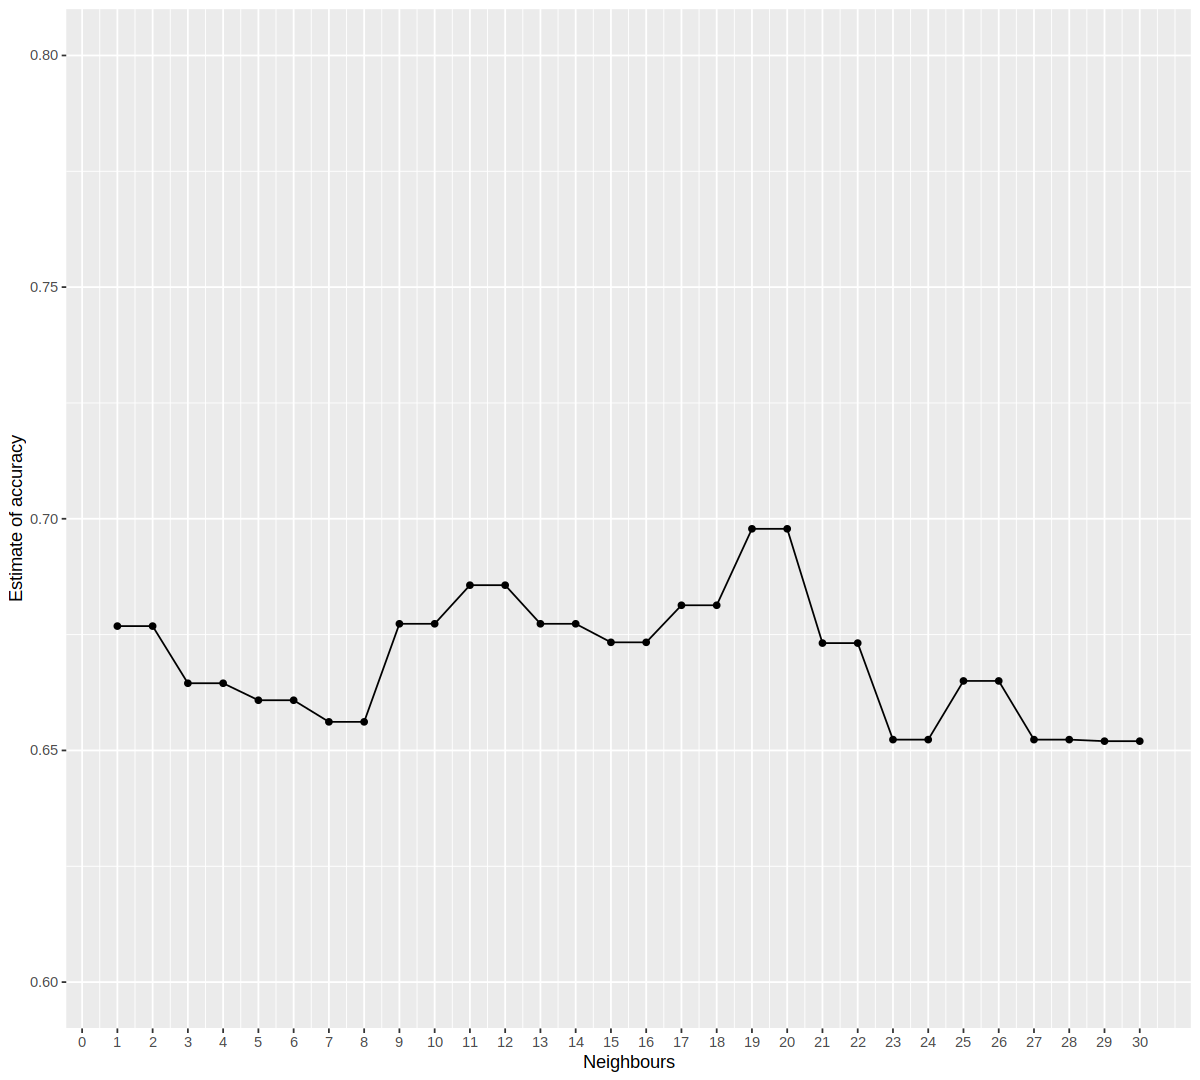

In [19]:
set.seed(1)

knn_recipe <- recipe(num ~., train_data) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("classification")

knn_workflow <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_tune)

heart_vfold <- vfold_cv(train_data, v = 5, strata = num)

k_values <- tibble(neighbors=seq(from = 1, to = 30))

knn_results <- knn_workflow |>
    tune_grid(resamples = heart_vfold, grid = k_values) |>
    collect_metrics()

accuracies <- knn_results |>
    filter(.metric == "accuracy")

cross_val_plot <- accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x="Neighbours", y="Estimate of accuracy")  + 
    scale_x_continuous(breaks = seq(from = 0, to = 30)) +  # adjusting the x-axis
    scale_y_continuous(limits = c(0.6, 0.8)) # adjusting the y-axis +
    ggtitle("Cross validation plot")

cross_val_plot

From the graph above, the optimal K value with the highest accuracy is around K = 19, so now we begin to train our K-NN classifier using 19 nearest neighbours. We use the same recipe as before, but create a new model specification (`knn_spec`), as the one before was specifically for tuning purposes. We add the recipe and model specification to the workflow (`heart_workflow`) and fit the training data (`heart_fit`) to finally complete the training of our classifier. The classifier is now ready to be used.

In [9]:
# k = 19
set.seed(1)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 19) |> 
      set_engine("kknn") |>
      set_mode("classification") 

heart_workflow <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec)

heart_fit <- heart_workflow |>
    fit(train_data)

heart_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(19,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.322314
Best kernel: rectangular
Best k: 19

In [10]:
# test prediction
set.seed(1)
heart_test_predictions <- predict(heart_fit, test_data) |>
      bind_cols(test_data)

head(heart_test_predictions)

.pred_class,cp,trestbps,chol,fbs,restecg,num
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,2,120,236,0,0,0
1,4,140,268,0,2,1
1,4,120,354,0,0,0
0,2,120,263,0,0,0
0,3,172,199,1,0,0
0,4,140,239,0,0,0


In [11]:
set.seed(1)
heart_prediction_accuracy <- heart_test_predictions |>
        metrics(truth = num, estimate = .pred_class)   

heart_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7704918
kap,binary,0.5328228


In [12]:
set.seed(1)
heart_mat <- heart_test_predictions |> 
      conf_mat(truth = num, estimate = .pred_class)

heart_mat

          Truth
Prediction  0  1
         0 28  9
         1  5 19

In [13]:
# REDO THIS

precision <- 18 / (8 + 18)

precision

recall <- 18 / (10 + 18)

recall

[1] 0.6923077

[1] 0.6428571

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


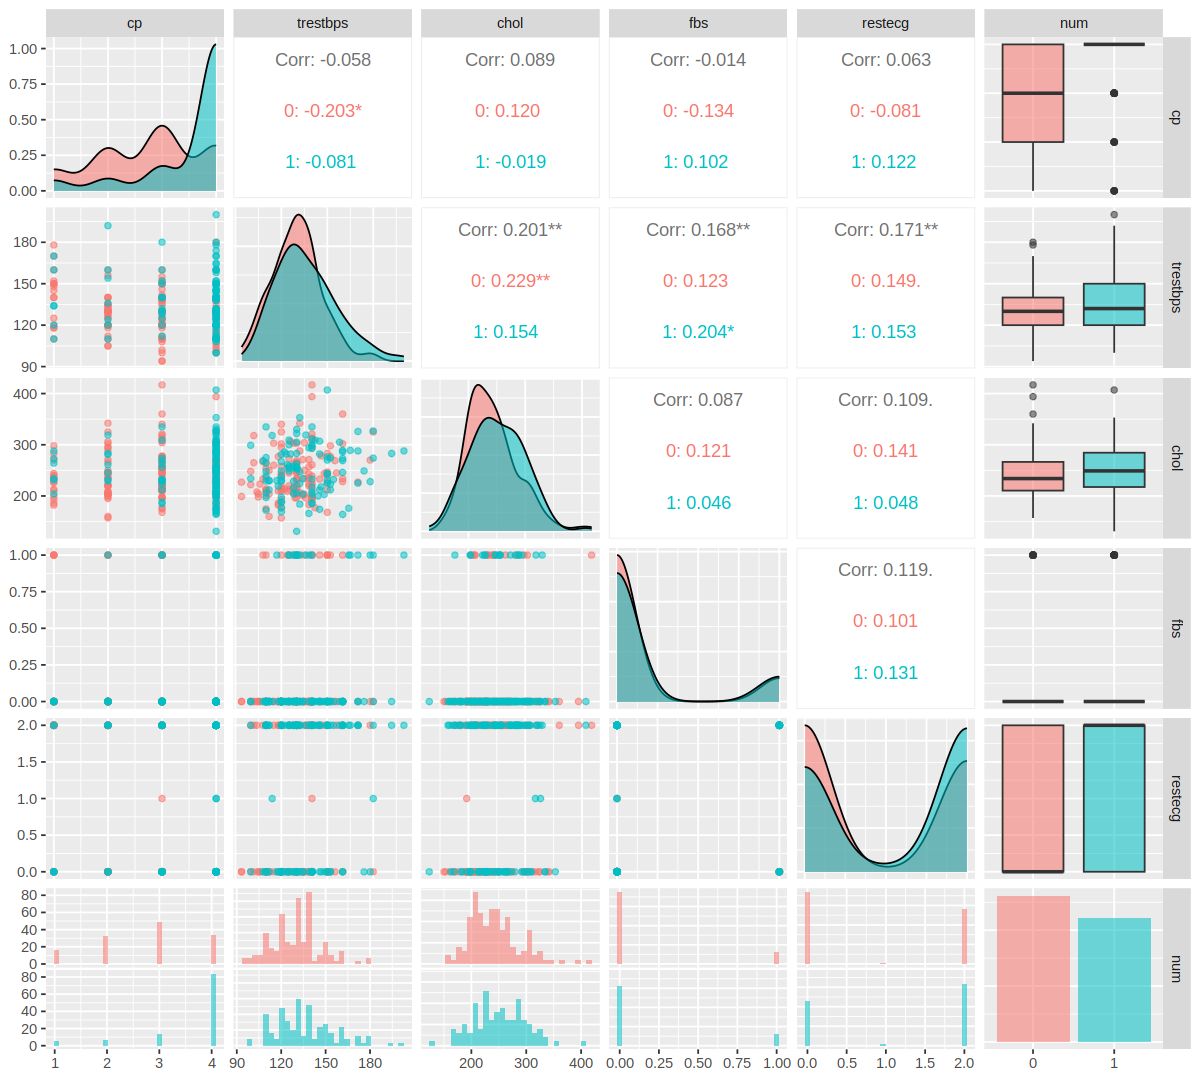

In [14]:
options(repr.plot.width = 10, repr.plot.height = 9)

heart_pairplot <- ggpairs(train_data, mapping = aes(color = num, alpha = 0.5))


# todo: scale_fill_brewer(palette = "Dark2")? 

# heart_pairplot2 <- train_data |>
#     ggpairs(mapping = aes(color = num, alpha = 0.5))

heart_pairplot

# heart_pairplot2 

# talk about the fact that we can't compare continuos and discrete

# trestbps (continuous) & chol (continuous) scatterplot: 0.201 corr | hard to tell
# - higher chol == higher trestbps for both heart disease + no disease





cp and num: People reporting cp type 4 are likely to have heart disease (people that have heart disease are likely to have cp type 4)

trestbps and num: people with no disease have lower resting blood pressure

chol and num: overall patients with disease have higher cholesterol as seen by the peak being further
                distribution for patients with disease is less concentrated around mean? / 

fbs and num: most of the patients have a fbs below 120 units

restecg and num: weak relationship between restecg and num. 2 has more patients with disease than restecg 0 and vice versa



discuss whether this is what you expected to find?

discuss what impact could such findings have?

discuss what future questions could this lead to?    